In [ ]:
%matplotlib inline

import warnings

import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as metrics
from scipy.io import loadmat

from imondrian.mondrianforest import MondrianForest
from imondrian.mondrianforest import process_command_line
from imondrian.mondrianforest_utils import load_data
from imondrian.mondrianforest_utils import precompute_minimal
from imondrian.mondrianforest_utils import reset_random_seed

warnings.filterwarnings('ignore')

In [2]:
class PDF:
    """
    Display PDF in jupyter
    https://stackoverflow.com/a/19470377/6923716
    """

    def __init__(self, pdf, size=(200, 200)):
        self.pdf = pdf
        self.size = size

    def _repr_html_(self):
        return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

    def _repr_latex_(self):
        return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

In [3]:
def format_data_dict(X, y):
    return {
        'is_sparse': False,
        'n_class': 2,
        'n_dim': len(X[0]),
        'n_train': len(X),
        'n_test': 0,
        'train_ids_partition': {
            'cumulative': {0: np.array(list(range(len(X))))},
            'current': {0: np.array(list(range(len(X))))}
        },
        'x_train': X,
        'y_train': y,
        'x_test': np.array([]),
        'y_test': np.array([]),
    }

In [4]:
def load_mat(path):
    """
    load matlab files
    format: X = Multi-dimensional point data, y = labels (1 = outliers, 0 = inliers)
    """
    data = loadmat(path)
    return data['X'].astype(float), data['y'].flatten().astype(int)

In [5]:
def load_csv(path, skip=1):
    data = np.genfromtxt(path, delimiter=',', dtype=None)[skip:]
    return data[:, :-1].astype(float), (data[:, -1] == b'"anomaly"').astype(int)

In [6]:
def train(X, y, num_trees=100, subsampling_size=256):
    argv = [
        '--n_minibatches', '1',
        '--n_mondrians', str(num_trees),
        '--budget', '-1',
        '--normalize_features', '1',
        '--optype', 'class',
        '--draw_mondrian', '0',
        '--isolate',
    ]

    settings = process_command_line(argv)

    reset_random_seed(settings)

    data = format_data_dict(X, y)
    
    param, cache = precompute_minimal(data, settings)

    mf = MondrianForest(settings, data)

    print(('Training on %d samples of dimension %d' %
           (data['n_train'], data['n_dim'])))

    train_ids_current_minibatch = data['train_ids_partition']['current'][0]
    mf.fit(data, train_ids_current_minibatch, settings, param, cache, subsampling_size=subsampling_size)

    print('\nFinal forest stats:')
    tree_stats = np.zeros((settings.n_mondrians, 2))
    tree_average_depth = np.zeros(settings.n_mondrians)
    for i_t, tree in enumerate(mf.forest):
        tree_stats[
            i_t, -
            2:
        ] = np.array([len(tree.leaf_nodes), len(tree.non_leaf_nodes)])
        tree_average_depth[i_t] = tree.get_average_depth(settings, data)[0]
    print(('mean(num_leaves) = {:.1f}, mean(num_non_leaves) = {:.1f}, mean(tree_average_depth) = {:.1f}'.format(
        np.mean(tree_stats[:, -2]), np.mean(tree_stats[:, -1]), np.mean(tree_average_depth))))
    print(('n_train = %d, log_2(n_train) = %.1f, mean(tree_average_depth) = %.1f +- %.1f' %
           (data['n_train'], np.log2(data['n_train']), np.mean(tree_average_depth), np.std(tree_average_depth))))

    return mf, settings, data

In [7]:
def evaluate(y_true, y_score):
    fpr, tpr, threshold = metrics.roc_curve(y_true, y_score)
    roc_auc = metrics.auc(fpr, tpr)

    print('N samples = ', len(y_true))
    print('% true outlier = ', np.count_nonzero(y_true) / len(y_true))
    print('auc =', roc_auc)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    return roc_auc

In [8]:
# DATASET_FILE = '/Users/gary/Downloads/cardio.mat'
# X, y = load_mat(DATASET_FILE)

DATASET_FILE = '/home/gary/school/imondrian-forests/algorithms_for_comparison/{x}/{x}_imondrian_tr.csv'.format(
    x='abalone',
)
X, y = load_csv(DATASET_FILE)

Training on 1024 samples of dimension 7

Final forest stats:
mean(num_leaves) = 256.0, mean(num_non_leaves) = 255.0, mean(tree_average_depth) = 12.4
n_train = 1024, log_2(n_train) = 10.0, mean(tree_average_depth) = 12.4 +- 1.2
N samples =  1024
% true outlier =  0.2001953125
auc = 0.6082998302510498


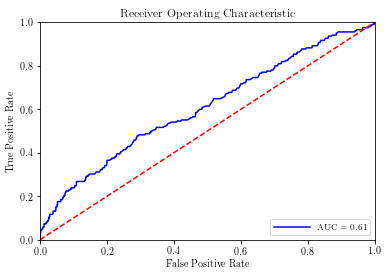

Training on 1024 samples of dimension 7

Final forest stats:
mean(num_leaves) = 256.0, mean(num_non_leaves) = 255.0, mean(tree_average_depth) = 12.3
n_train = 1024, log_2(n_train) = 10.0, mean(tree_average_depth) = 12.3 +- 1.1
N samples =  1024
% true outlier =  0.2001953125
auc = 0.6574406623187111


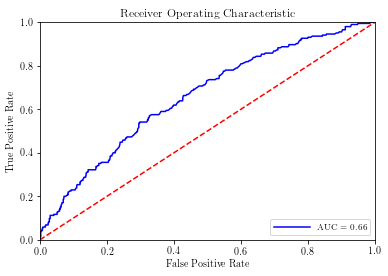

Training on 1024 samples of dimension 7

Final forest stats:
mean(num_leaves) = 256.0, mean(num_non_leaves) = 255.0, mean(tree_average_depth) = 12.5
n_train = 1024, log_2(n_train) = 10.0, mean(tree_average_depth) = 12.5 +- 1.0
N samples =  1024
% true outlier =  0.2001953125
auc = 0.6496441228148544


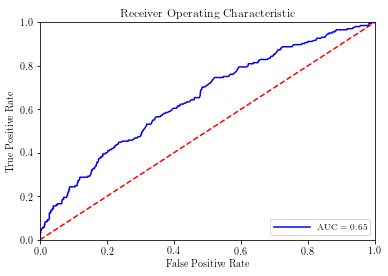

Training on 1024 samples of dimension 7

Final forest stats:
mean(num_leaves) = 256.0, mean(num_non_leaves) = 255.0, mean(tree_average_depth) = 12.5
n_train = 1024, log_2(n_train) = 10.0, mean(tree_average_depth) = 12.5 +- 1.2
N samples =  1024
% true outlier =  0.2001953125
auc = 0.6586557074361953


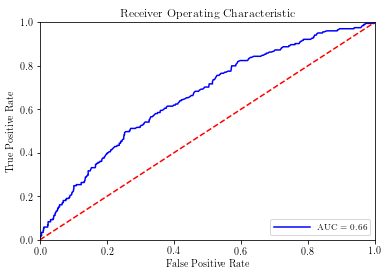

Training on 1024 samples of dimension 7

Final forest stats:
mean(num_leaves) = 256.0, mean(num_non_leaves) = 255.0, mean(tree_average_depth) = 12.4
n_train = 1024, log_2(n_train) = 10.0, mean(tree_average_depth) = 12.4 +- 1.3
N samples =  1024
% true outlier =  0.2001953125
auc = 0.6558444265761338


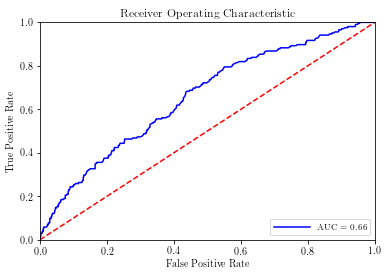

mean auc over 5 runs =  0.6459769498793889


In [9]:
aucs = []
N = 5
for _ in range(N):
    mf, settings, data = train(X, y, num_trees=100)
    aucs.append(evaluate(y, mf.get_anomaly_scores(X)))

print(f'mean auc over {N} runs = ', np.mean(np.array(aucs)))